In [1]:
include("../src/GaussianFilters.jl")
using .GaussianFilters # . done before adding to package repo

using LinearAlgebra
using Distributions
using Random

Random.seed!(1);

2D Example motion example where you provide x and y force directly through an object; u = \[Fx, Fy\].

As such a = F/m, discrete dV = adt = F/mdt. Let state vector x consist of \[px, vx, py, vy\]

In [2]:
dt = 0.1
m = 50
A = [1 dt 0 0 ; 0 1 0 0 ; 0 0 1 dt; 0 0 0 1]
B = [0 0; dt/m 0; 0 0; 0 dt/m]
W = 2*Matrix{Float64}(I,4,4)
dmodel = LinearDynamicsModel(A,B,W)

LinearDynamicsModel{Float64,Float64,Float64}([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.002 0.0; 0.0 0.0; 0.0 0.002], [2.0 0.0 0.0 0.0; 0.0 2.0 0.0 0.0; 0.0 0.0 2.0 0.0; 0.0 0.0 0.0 2.0])

Assume we can noisily measure velocity

In [3]:
C = [0 1.0 0 0; 0 0 0 1.0]
V = 2*Matrix{Float64}(I,2,2)
omodel = LinearObservationModel(C,V)
kf = KalmanFilter(dmodel,omodel)

KalmanFilter(LinearDynamicsModel{Float64,Float64,Float64}([1.0 0.1 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.1; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.002 0.0; 0.0 0.0; 0.0 0.002], [2.0 0.0 0.0 0.0; 0.0 2.0 0.0 0.0; 0.0 0.0 2.0 0.0; 0.0 0.0 0.0 2.0]), LinearObservationModel{Float64,Bool,Float64}([0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0], Bool[false false; false false], [2.0 0.0; 0.0 2.0]))

In [4]:
kf.d.W

4×4 Symmetric{Float64,Array{Float64,2}}:
 2.0  0.0  0.0  0.0
 0.0  2.0  0.0  0.0
 0.0  0.0  2.0  0.0
 0.0  0.0  0.0  2.0

Initialize belief, generate action sequence (forces in a circle), simulate model 

In [10]:
times = 0:dt:10
Fmag = 1000
action_sequence = [[Fmag*cos(t), Fmag*sin(t)] for t in times]
b0 = GaussianBelief([0.0,0.0,0.0,0.0], 2.0*Matrix{Float64}(I,4,4))

sim_states, sim_measurements = simulation(b0,action_sequence,kf)

(Array{Float64,1}[[-0.0233883, -0.771006, 0.188429, -0.0307094], [2.20848, 1.12473, 0.198476, 1.37911], [2.57996, 3.01886, -1.94447, 2.88357], [7.3003, 3.54722, -2.06221, 5.46942], [8.08037, 9.30228, -1.49048, 7.56835], [7.3545, 12.111, -1.81776, 5.63337], [9.99438, 14.8961, 1.43499, 6.07053], [15.0879, 14.9296, 0.110602, 6.69035], [17.6574, 13.8381, 3.02963, 8.12331], [18.1407, 14.8385, 5.23924, 9.3341]  …  [73.5567, 14.9781, 197.284, 39.1071], [77.5935, 11.7177, 201.826, 36.7653], [76.9509, 10.5109, 204.618, 35.0597], [79.1657, 8.05636, 208.84, 35.4014], [81.027, 5.23827, 213.435, 35.5039], [83.5402, 4.36501, 220.373, 35.6346], [82.1202, 2.40328, 224.773, 34.5503], [80.6469, 5.07665, 230.053, 34.3385], [82.3491, 2.35849, 234.772, 34.33], [81.8743, 2.3118, 238.715, 30.8865]], Any[[2.20848, 1.12473, 0.198476, 1.37911], [2.57996, 3.01886, -1.94447, 2.88357], [7.3003, 3.54722, -2.06221, 5.46942], [8.08037, 9.30228, -1.49048, 7.56835], [7.3545, 12.111, -1.81776, 5.63337], [9.99438, 14.896

### Plot

In [6]:
using Plots

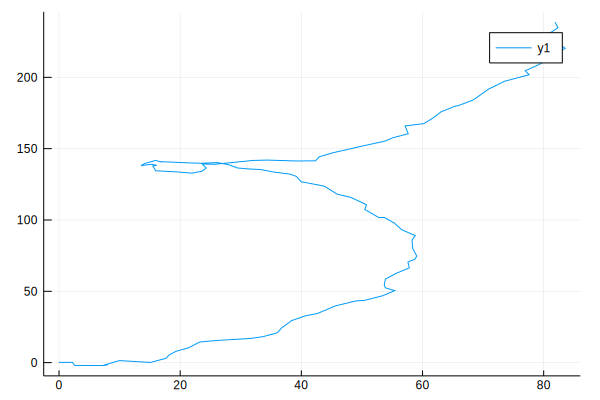

In [11]:
x = [x[1] for x in sim_states]
y = [x[3] for x in sim_states]
plot(x, y)

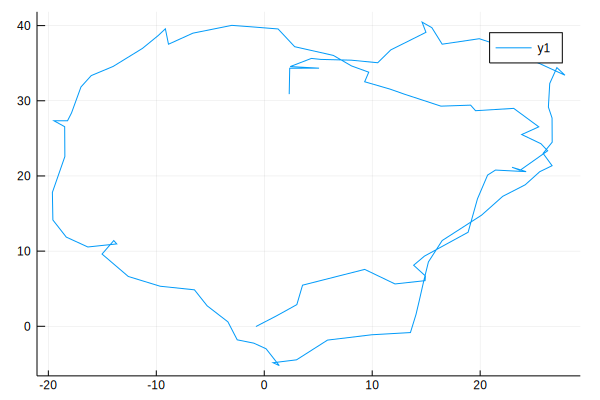

In [12]:
vx = [x[2] for x in sim_states]
vy = [x[4] for x in sim_states]
plot(vx, vy)